In [1]:
#Import libraries:

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from astropy.modeling import models, fitting
from scipy import odr

from urllib.error import HTTPError

from multiprocessing import Pool, cpu_count

# Estimation of the heavy temperature with fluctuations: $t^2 > 0$ 

In [2]:
## Update the new tables:

total_abundances = pd.read_csv('total_abundances_t2geq0.txt', delim_whitespace = ' ') #Total abundances
ionic_abundances = pd.read_csv('ionic_abundances_t2geq0.txt', delim_whitespace = ' ') #Ionic abundances
physical_conditions = pd.read_csv('physical_conditions.txt', delim_whitespace = ' ') #Physical_condtions

#Filter the regions by its name

#HII Regions: 

total_HII_filter = total_abundances[total_abundances['File'].str.startswith('HII_')]
ionic_HII_filter = ionic_abundances[ionic_abundances['File'].str.startswith('HII_')]
physical_HII_filter = physical_conditions[physical_conditions['File'].str.startswith('HII_')]

#SFG Regions:

total_SFG_filter = total_abundances[total_abundances['File'].str.startswith('SFG_')]
ionic_SFG_filter = ionic_abundances[ionic_abundances['File'].str.startswith('SFG_')]
physical_SFG_filter = physical_conditions[physical_conditions['File'].str.startswith('SFG_')]

#See the total number of regions:
print('Este es el número total de regiones HII:', len(total_HII_filter))
print('Este es el número total de regiones SFG:', len(total_SFG_filter))
print('Este es el número total de conjunto de HII y SFG:', len(total_HII_filter) + len(total_SFG_filter))

Este es el número total de regiones HII: 1263
Este es el número total de regiones SFG: 1459
Este es el número total de conjunto de HII y SFG: 2722


## Estimation of $T_{heavy}$

We'll estimatie $T_{heavy}$ with its uncertainties using MonteCarlo.

Equation for $T_{heavy}$ is:


$$ T_{heavy} = \dfrac{\text{OIII}}{\text{O}}T_e[\text{OIII}] + \dfrac{\text{OII}}{\text{O}}T_e[\text{NII}] $$

We have to recall that by definition we have the next important relations:

$$ \log\left( \text{OIII/H} \right) + 12 =  \epsilon(\text{OIII}) $$


$$ \log\left( \text{OII/H} \right ) + 12 = \epsilon( \text{OII} ) $$

$$ log\left( \text{O/H} \right) + 12 = \epsilon( \text{O} ) $$

simplifying the expresion then we have:

$$ T_{heavy} = 10^{( \text{OIII} - \text{O}) }T_e[\text{OIII}] + 10^{( \text{OII} - \text{OII})}T_e[\text{NII}]$$

In [3]:
## This function estimate our lineal fit using ODR:

def linfit(x, y, xerr_low, xerr_high, yerr_low, yerr_high):
    """
    Perform a lineal fit to data with asymmetric uncertainties in x and y using Orthogonal Distance Regression (ODR)
    
    Parametres: 
        x = Data in the x axis (1D Array)
        y = Data in the y axis (1D Array)
        xerr_low = Lower error in x (1D Array)
        xerr_high = Upper error in x (1D Array)
        yerr_low = Lower error in y (1D Array)
        yerr_high = Upper error in y (1D Array)
    
    
    Return: m, e_m, c, e_c, correlation_coefficient
        m = Slope (Scalar)
        e_m = Error in the Slope (Scalar)
        c = Intercept (Scalar)
        e_c = Error in the Intercept (Scalar)
        correlation_coefficient = Correlation coefficient between the parametres (Scalar)
    """
    #Make conditionals:
    
    if xerr_high is None and xerr_low is None:
        raise  ValueError("At least one of x errors must be provided.")
    elif xerr_high is None:
        x_e = xerr_low
    elif xerr_low is None:
        x_e = xerr_high
    else:
        x_e = (xerr_high + xerr_low)/2
        
    if yerr_high is None and yerr_low is None:
        raise ValueError('At least one of y erros must be provided.')
    elif yerr_high is None:
        y_e = yerr_low
    elif yerr_low is None:
        y_e = yerr_high
    else:
        y_e = (yerr_high + yerr_low)/2
    
    #Define the lineal function
    
    def func(p, x):

        m,b = p
        return m*x + b
 
    quad_model = odr.Model(func)
    
    # Create a RealData object
    data = odr.RealData(x,y, sx=x_e, sy=y_e)

    # Set up ODR with the model and data.
    odr_instance = odr.ODR(data, quad_model, beta0=[0., 1.])

    # Run the regression.
    out = odr_instance.run()

    #print fit parameters and 1-sigma estimates
    popt = out.beta
    perr = out.sd_beta
  
    c=popt[1]
    e_c=perr[1]
    
    m=popt[0]
    e_m=perr[0]

    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = stats.pearsonr(x, y)
    
    return  c, e_c, m, e_m, correlation_coefficient


# This function estimate a quadratic adjustment:

def quadratic_fit(x, y, xerr_low, xerr_high, yerr_low, yerr_high):
    """
    Perform a quadratic fit to data with asymmetric uncertainties in x and y using Orthogonal Distance Regression (ODR).

    Parameters:
        x (array-like): 1D array of x-axis data.
        y (array-like): 1D array of y-axis data.
        xerr_low (array-like): Lower uncertainties in x.
        xerr_high (array-like): Upper uncertainties in x.
        yerr_low (array-like): Lower uncertainties in y.
        yerr_high (array-like): Upper uncertainties in y.

    Returns:
        a (float): Quadratic coefficient (x^2 term).
        e_a (float): Error in the quadratic coefficient.
        b (float): Linear coefficient (x term).
        e_b (float): Error in the linear coefficient.
        c (float): Intercept (constant term).
        e_c (float): Error in the intercept.
        correlation_coefficient (float): Pearson correlation coefficient between x and y.
    """
    
    #Make conditionals:
    
    if xerr_high is None and xerr_low is None:
        raise  ValueError("At least one of x errors must be provided.")
    elif xerr_high is None:
        x_e = xerr_low
    elif xerr_low is None:
        x_e = xerr_high
    else:
        x_e = (xerr_high + xerr_low)/2
        
    if yerr_high is None and yerr_low is None:
        raise ValueError('At least one of y erros must be provided.')
    elif yerr_high is None:
        y_e = yerr_low
    elif yerr_low is None:
        y_e = yerr_high
    else:
        y_e = (yerr_high + yerr_low)/2
        
    #Define the shape of the function, in this case is quadratic:
    def quadratic(theta,x):
        a, b, c = theta
        model = a*x**2 + b*x + c
        return model
 
    quad_model = odr.Model(quadratic)
    
    # Create a RealData object
    data = odr.RealData(x, y, sx=x_e, sy=y_e)

    # Set up ODR with the model and data.
    odr_instance = odr.ODR(data, quad_model, beta0=[0., 1., 1.])

    # Run the regression.
    out = odr_instance.run()

    #print fit parameters and 1-sigma estimates
    popt = out.beta
    perr = out.sd_beta
    
    a=popt[0]
    e_a=perr[0]
    
    b=popt[1]
    e_b=perr[1]
    
    c = popt[2]
    e_c = perr[2]
    


    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = stats.pearsonr(x, y)
    
    return  a, e_a, b, e_b,c, e_c, correlation_coefficient

#This function estimate T_heavy and their uncertainties:

def T_heavy(Name, O3, O2, O, Te_O3, Te_Ne, e_Om, e_Op, e_Te_O3m, e_Te_O3p, e_Te_Nem, e_Te_Nep):
    
    """
    Estimate the heavy element temperature (T_heavy) in ionized regions using ionic oxygen abundances and 
    electron temperatures derived from [OIII] and [NII] emission lines. Also calculates asymmetric uncertainties 
    using Monte Carlo simulations.

    Parameters:
        Name (pd.Series): Identifiers for the observed regions (e.g., HII or SFG regions).
        O3 (pd.Series): Ionic abundance of [OIII] (O++/H+).
        O2 (pd.Series): Ionic abundance of [OII] (O+/H+).
        O (pd.Series): Total abundance of Oxygen (O/H).
        Te_O3 (pd.Series): Electron temperature derived from [OIII] emission.
        Te_Ne (pd.Series): Electron temperature derived from [NII] emission.
        e_Om (pd.Series): Lower uncertainty on total Oxygen abundance.
        e_Op (pd.Series): Upper uncertainty on total Oxygen abundance.
        e_Te_O3m (pd.Series): Lower uncertainty on Te_O3.
        e_Te_O3p (pd.Series): Upper uncertainty on Te_O3.
        e_Te_Nem (pd.Series): Lower uncertainty on Te_Ne.
        e_Te_Nep (pd.Series): Upper uncertainty on Te_Ne.

    Returns:
        pd.DataFrame: A dataframe with the following columns:
            - Name: Region identifier.
            - O3_abundance: Ionic abundance of [OIII].
            - O2_abundance: Ionic abundance of [OII].
            - O_abundance: Total Oxygen abundance.
            - e_O_abundancem: Lower uncertainty of O_abundance.
            - e_O_abundancep: Upper uncertainty of O_abundance.
            - Te_[OIII]: Electron temperature from [OIII].
            - e_Te_[OIII]m: Lower uncertainty of Te_[OIII].
            - e_Te_[OIII]p: Upper uncertainty of Te_[OIII].
            - Te_[NeII]: Electron temperature from [NII].
            - e_Te_[NeII]m: Lower uncertainty of Te_[NeII].
            - e_Te_[NeII]p: Upper uncertainty of Te_[NeII].
            - T_heavy: Estimated heavy element temperature.
            - e_T_heavy: Lower uncertainty of T_heavy.
            - E_T_heavy: Upper uncertainty of T_heavy.

    Notes:
        The function uses a Monte Carlo method with 10,000 samples to propagate the uncertainties in the input 
        temperatures into the final T_heavy value. It assumes that the electron temperature errors are symmetric
        and follows a normal distribution.
    """
    
    #Mask: This mask quit all the nan's values
    
    mask = ~np.isnan(O3) & ~np.isnan(O2) & ~np.isnan(O) & ~np.isnan(Te_O3) & ~np.isnan(Te_Ne) & ~np.isnan(e_Te_O3m) &\
            ~np.isnan(e_Te_O3p) & ~np.isnan(e_Te_Nem) & ~np.isnan(e_Te_Nep) & ~np.isnan(e_Om) & ~np.isnan(e_Op)
    
    #Apply mask:
    Name= Name[mask].reset_index(drop=True)
    O3= O3[mask].reset_index(drop =True)
    O2 = O2[mask].reset_index(drop=True)
    O = O[mask].reset_index(drop=True)
    Te_O3 = Te_O3[mask].reset_index(drop=True)
    Te_Ne = Te_Ne[mask].reset_index(drop=True)
    e_Om = e_Om[mask].reset_index(drop = True)
    e_Op = e_Op[mask].reset_index(drop = True)
    e_Te_O3m = e_Te_O3m[mask].reset_index(drop=True)
    e_Te_O3p = e_Te_O3p[mask].reset_index(drop=True)
    e_Te_Nem = e_Te_Nem[mask].reset_index(drop=True)
    e_Te_Nep = e_Te_Nep[mask].reset_index(drop=True)
    
    #T_heavy:
    T = 10**(O3 - O)*Te_O3 + 10**(O2 - O)*Te_Ne
    
    #Create the MonteCarlo Simulations:
    
    #Sample Number of MonteCarlo
    n_samples = 100000
    
    #Empthy listes:

    e_T_list = [] #Arreglo vacio que almacenará los datos del error minus
    E_T_list = [] #Arreglo vacio que almacenará los datos del error plus

    #Vamos a crear una serie de simulaciones MonteCarlo para cada row de nuestro dataframe:
    
    #Hacemos una simulación MonteCarlo de 100000 muestras para cada Row de nuestro dataframe
        
    T_samples = np.random.standard_normal(n_samples)
    
    for i in range(len(O3)):
        
        #First term of T_{heavy}:
        T_heavy1 = T_samples*(e_Te_O3m[i]/2 + e_Te_O3p[i]/2)*10**(O3[i] - O[i]) + 10**(O3[i] - O[i])*Te_O3[i]
      
        #Second term of T_{heavy}:
        T_heavy2 = T_samples*(e_Te_Nem[i]/2 + e_Te_Nep[i]/2)*10**(O2[i] - O[i]) + 10**(O2[i] - O[i])*Te_Ne[i]
    
        #Sum of our function:
        T_sum = T_heavy1 + T_heavy2
        
        #T_central:
        T_central = np.median(T_sum)
    
        #Erros:
        e_Thp = round(np.percentile(T_sum, 84) - T_central,2)
        e_Thm = round(T_central - np.percentile(T_sum, 16),2)
        
        #Concatenar:
    
        e_T_list = np.append(e_T_list, np.absolute(e_Thm))
        E_T_list = np.append(E_T_list, np.absolute(e_Thp)) 
    
    if Name[0].startswith('HII'):
        print('Total HII regions:', len(O3), '\n')
    else:
        print('Total SFG regions:', len(O3), '\n')
    
    
    data = {'Name': Name, 'O3_abundance': O3,'O2_abundance': O2,'O_abundance': O,'e_O_abundancem': e_Om,
        'e_O_abundancep': e_Op, 'Te_[OIII]': Te_O3, 'e_Te_[OIII]m': e_Te_O3m,'e_Te_[OIII]p': e_Te_O3p, 
        'Te_[NeII]': Te_Ne, 'e_Te_[NeII]m': e_Te_Nem,'e_Te_[NeII]p': e_Te_Nep, 'T_heavy': T, 'e_T_heavy': e_T_list,
        'E_T_heavy': E_T_list}
    
    return pd.DataFrame(data)

#This function is going to choose the model to apply asking the using what model use:

def model(T, O, e_T_list, E_T_list, e_Om, e_Op, model_type = None):
    
    """
    Fit a model (linear or quadratic) to the relationship between temperature and oxygen abundance,
    accounting for asymmetric uncertainties using Orthogonal Distance Regression (ODR). Also provides
    standard regression fits for comparison (using `linregress` for linear and `np.polyfit` for quadratic).

    Parameters:
        T (pd.Series or np.ndarray): Temperature values (e.g., T_heavy).
        O (pd.Series or np.ndarray): Oxygen abundances corresponding to each temperature value.
        e_T_list (pd.Series or np.ndarray): Lower uncertainties on temperature values.
        E_T_list (pd.Series or np.ndarray): Upper uncertainties on temperature values.
        e_Om (pd.Series or np.ndarray): Lower uncertainties on oxygen abundance values.
        e_Op (pd.Series or np.ndarray): Upper uncertainties on oxygen abundance values.
        model_type (str, optional): Type of model to fit. Must be 'Lineal' or 'Quadratic'. 
                                    If None, the function prompts the user to choose.

    Returns:
        tuple:
            If model_type == 'Lineal':
                - ODR (tuple): Parameters from the linear ODR fit.
                - Linre (LinregressResult): Output from `scipy.stats.linregress`.
                - ODR_Residual (np.ndarray): Residuals from ODR linear fit.
                - Linre_Residual (np.ndarray): Residuals from `linregress` linear fit.
            
            If model_type == 'Quadratic':
                - ODR_Quadratic (tuple): Parameters from the quadratic ODR fit.
                - Polyfit (np.ndarray): Coefficients from `np.polyfit` quadratic fit (order 2).
                - ODR_Quadratic_Residual (np.ndarray): Residuals from ODR quadratic fit.
                - Polyfit_Quadratic_Residual (np.ndarray): Residuals from `np.polyfit` quadratic fit.

    Raises:
        ValueError: If `model_type` is not 'Lineal' or 'Quadratic'.

    Notes:
        - ODR accounts for uncertainties in both independent and dependent variables.
        - `linregress` is used for a simple least-squares linear model without error consideration.
        - `np.polyfit` is used for standard quadratic fitting without error propagation.
        - Residuals represent the difference between observed oxygen abundances and model predictions.
    """
    
    #Apply Model:
    
    if model_type is None:
        model_type = input("Choose model type ('Lineal' or 'Quadratic'): ").strip().capitalize()
        
    if model_type == 'Lineal': 
        #Lineals
        ODR = linfit(T, O, e_T_list, E_T_list, e_Om, e_Op)
        print('These are the parameters for the Lineal adjustment ODR:\n',  ODR, '\n')
        
        Linre = stats.linregress(T, O)
        print('These are the parametres for the Lineal adjustment Linregress:\n', Linre, '\n')
        
        #Model:
        y = ODR[0] + ODR[2]*T
        y2 = Linre[1] + Linre[0]*T
        
        #Residual:
        ODR_Residual = O - y
        Linre_Residual = O - y2
        
        return ODR, Linre, ODR_Residual, Linre_Residual
    
    elif model_type == 'Quadratic':
        #Quadratic
        ODR_Quadratic = quadratic_fit(T, O, e_T_list, E_T_list,e_Om, e_Op)
        print('These are the parametres for the Quadratic adjustment ODR: \n', ODR_Quadratic, '\n')
        
        Polyfit = np.polyfit(T, O, 2)
        print('These are the parametres for the Quadratic adjustment Polifit:\n', Polyfit, '\n')
        
        #Model:
        y3 = ODR_Quadratic[4] + ODR_Quadratic[2]*T + ODR_Quadratic[0]*T**2
        y4 = Polyfit[2] + Polyfit[1]*T + Polyfit[0]*T**2
        
        #Residual:
        ODR_Quadratic_Residual = O - y3
        Polyfit_Quadratic_Residual = O - y4
        
        return ODR_Quadratic, Polyfit, ODR_Quadratic_Residual, Polyfit_Quadratic_Residual
    
    else:
        raise ValueError("model_type must be 'Lineal' or 'Quadratic'")

#Create simple plots:

def plot(x, y, xerr_low, xerr_high, yerr_low, yerr_high):
    """
    Parameters:
        x (array-like): Values of T_heavy (temperature).
        y (array-like): Oxygen abundance values (12 + log(O/H)).
        xerr_low (array-like): Lower uncertainties for x (T_heavy).
        xerr_high (array-like): Upper uncertainties for x (T_heavy).
        yerr_low (array-like): Lower uncertainties for y (oxygen abundance).
        yerr_high (array-like): Upper uncertainties for y (oxygen abundance).

    Returns:
        None: Displays a matplotlib plot with asymmetric error bars.
    """
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.errorbar(x, y, fmt='s', xerr = [xerr_low, xerr_high], yerr = [yerr_low, yerr_high], elinewidth = 2, mec = 'k',
                mfc = 'k', capsize=3, capthick = 2, ecolor= 'gray', label='Data with t$^2$ = 0', alpha = 0.7)
    ax.set_ylabel('$12 + log(O/H)$', size = 12)
    ax.set_xlabel('$T_{heavy}$', size = 12)
    ax.set_title('$12 + \log(O/H)$ vs $T_{heavy}$  with $t^2$ = 0', size = 14)
    ax.grid(False)
    ax.minorticks_on() #minorticks on
    ax.tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True)
    ax.legend()
    plt.show()

Total SFG regions: 44 

Total HII regions: 230 



<IPython.core.display.Javascript object>


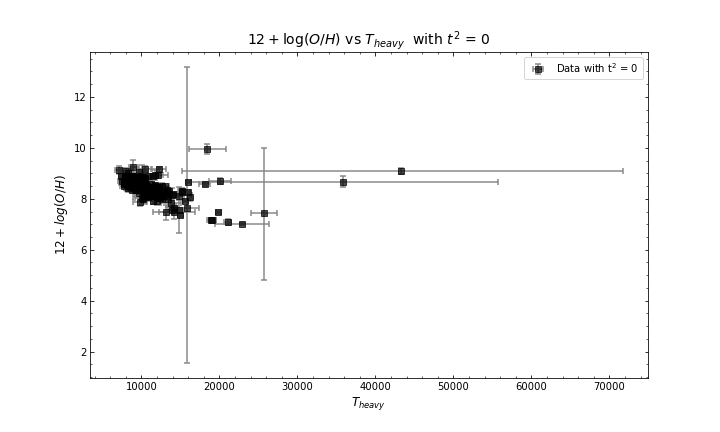

,index,Name,O3_abundance,O2_abundance,O_abundance,e_O_abundancem,e_O_abundancep,Te_[OIII],e_Te_[OIII]m,e_Te_[OIII]p,Te_[NeII],e_Te_[NeII]m,e_Te_[NeII]p,T_heavy,e_T_heavy,E_T_heavy
0,0,SFG__1159+545__1159+545__Izotov__94__,7.463,6.328,7.624,6.076,5.560,19171.18,470.33,671.43,52262.37,11801.30,31681.75,15876.271087,1487.85,1488.61
1,1,SFG__HS0837+4717__HS0837+4717__Izotov__04__,7.493,6.250,7.439,2.608,2.557,19368.31,245.24,214.19,58174.95,14675.87,28109.38,25697.430211,1638.00,1638.84
2,2,SFG__HS0924+3821__HS0924+3821__Izotov__04__,7.931,7.286,7.996,0.308,0.324,12439.46,166.32,215.27,13892.29,1880.81,2972.46,13419.078004,634.90,635.22
3,3,SFG__HS1213+3636A__HS1213+3636A__Izotov__04__,7.890,7.691,8.099,0.193,0.192,10652.44,274.57,229.38,12419.14,2017.19,1961.03,11437.290424,929.44,929.92
4,4,SFG__HS1851p6933__HS1851p6933__Izotov__21b__,8.241,7.025,8.266,0.033,0.033,16134.06,367.09,329.49,12199.87,441.41,289.62,15931.949442,348.40,348.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,225,HII__SMC__NGC456-2__PenaGuerrero__12__,8.214,7.544,8.300,0.122,0.120,12089.50,266.08,151.26,11075.73,841.30,955.03,11860.190684,325.33,329.58
270,226,HII__SMC__NGC456-a-1__Guseva__11__,8.121,7.667,8.255,0.076,0.073,12167.86,95.71,105.28,11514.88,713.10,717.38,11910.903538,255.85,259.19
271,227,HII__SMC__NGC456-a-3-m__Guseva__11__,8.047,7.471,8.144,0.093,0.090,11951.43,81.23,96.14,12031.53,1079.28,997.38,12113.751055,288.40,292.16
272,228,HII__SMC__NGC456-a1__Guseva__11__,8.044,7.635,8.187,0.039,0.045,12176.60,79.81,87.73,11883.36,327.49,461.32,12094.240213,169.16,171.37


In [4]:
#Use the functions:

SFG = T_heavy(ionic_SFG_filter['File'], ionic_SFG_filter['O3_abundance'], ionic_SFG_filter['O2_abundance'], \
               total_SFG_filter['O_abundance'], physical_SFG_filter['Te_[OIII]_4363_5007'], \
                physical_SFG_filter['Te_[NII]_5755_6584'], total_SFG_filter['e_O_abundancem'], \
                total_SFG_filter['e_O_abundancep'], physical_SFG_filter['e_Te_[OIII]_4363_5007m'], \
                physical_SFG_filter['e_Te_[OIII]_4363_5007p'], physical_SFG_filter['e_Te_[NII]_5755_6584m'], \
               physical_SFG_filter['e_Te_[NII]_5755_6584p'])

HII = T_heavy(ionic_HII_filter['File'], ionic_HII_filter['O3_abundance'], ionic_HII_filter['O2_abundance'], \
               total_HII_filter['O_abundance'], physical_HII_filter['Te_[OIII]_4363_5007'],\
                physical_HII_filter['Te_[NII]_5755_6584'], total_HII_filter['e_O_abundancem'], \
                total_HII_filter['e_O_abundancep'],physical_HII_filter['e_Te_[OIII]_4363_5007m'], \
               physical_HII_filter['e_Te_[OIII]_4363_5007p'], physical_HII_filter['e_Te_[NII]_5755_6584m'], \
               physical_HII_filter['e_Te_[NII]_5755_6584p'])


#Create a New DataFrame with the total of the regions:
Regions = pd.concat([SFG, HII])
Regions = Regions.reset_index()

#See the plot:

plot(Regions['T_heavy'], Regions['O_abundance'], Regions['e_T_heavy'], Regions['E_T_heavy'],
                   Regions['e_O_abundancem'], Regions['e_O_abundancep'])
#See the table:
Regions

<IPython.core.display.Javascript object>


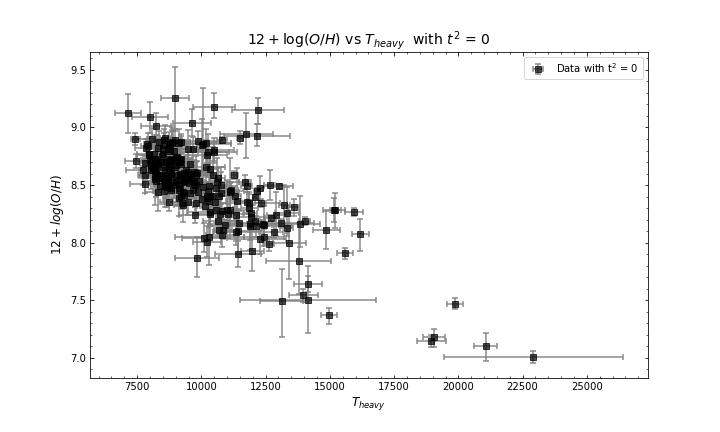

In [5]:
#See that we have outlier, we'll clean it manually:

#Outlier for total regions:

outlier = Regions[(Regions['O_abundance'] > 8.51) & (Regions['O_abundance'] < 10) & (Regions['T_heavy'] > 1.49e4) &\
                  (Regions['T_heavy'] < 5e4)]

outlier2 = Regions[(Regions['e_O_abundancem'] > 0.9) & (Regions['e_O_abundancem'] < 10)]


outlier3 = HII[(HII['O_abundance'] > 8.51) & (HII['O_abundance'] < 10) & (HII['T_heavy'] > 1.49e4) &\
                  (HII['T_heavy'] < 5e4)]

outlier4 = HII[(HII['e_O_abundancem'] > 0.9) & (HII['e_O_abundancem'] < 10)]

#Outlier for SFG regions:

outlier5 = SFG[(SFG['O_abundance'] > 8.51) & (SFG['O_abundance'] < 10) & (SFG['T_heavy'] > 1.49e4) &\
                  (SFG['T_heavy'] < 5e4)]

outlier6 = SFG[(SFG['e_O_abundancem'] > 0.9) & (SFG['e_O_abundancem'] < 10)]
    
#Total Regions:
Regions = Regions.drop(outlier.index)
Regions = Regions.drop(outlier2.index)

#HII regions:

HII = HII.drop(outlier3.index)
HII = HII.drop(outlier4.index)
HII = HII.reset_index(drop = True)

#SFG regions:
SFG = SFG.drop(outlier5.index)
SFG = SFG.drop(outlier6.index)
SFG = SFG.reset_index(drop = True)

plot(Regions['T_heavy'], Regions['O_abundance'], Regions['e_T_heavy'], Regions['E_T_heavy'],
                   Regions['e_O_abundancem'], Regions['e_O_abundancep'])

In [14]:
# Create the Adjustment:

#Use 'Regions' to make Lineal adjustment ODR:

Lineal_Model = model(Regions['T_heavy'], Regions['O_abundance'], Regions['e_T_heavy'], Regions['E_T_heavy'], 
            Regions['e_O_abundancem'], Regions['e_O_abundancep'])




Choose model type ('Lineal' or 'Quadratic'): Lineal
These are the parameters for the Lineal adjustment ODR:
 (9.633296590285356, 0.05585219304713124, -0.00011524892487151378, 5.552807695814035e-06, -0.7681108011290577) 

These are the parametres for the Lineal adjustment Linregress:
 LinregressResult(slope=-0.00011492469706727798, intercept=9.652428125370571, rvalue=-0.768110801129058, pvalue=7.706879406412819e-53, stderr=5.907539306227054e-06, intercept_stderr=0.0617081827099494) 



<IPython.core.display.Javascript object>


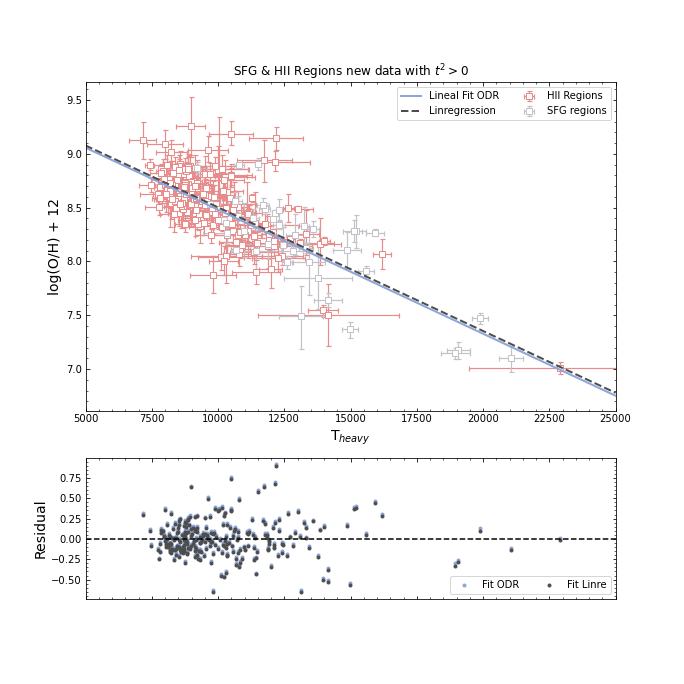

Slope ORD: -0.000115 ± 0.000006
Intercept ORD: 9.633297 ± 0.055852 

Slope Linregress: -0.000115 ± 0.000006
Intercept Linregress:  9.6524 ± 0.0617


In [16]:
#Lineal Model Plot:

fig, ax = plt.subplots(2, 1, figsize=(9.5, 9.5), sharex=False, gridspec_kw={'height_ratios': [3.5, 1.5]})

#X axis for the adjustment:
x = np.linspace(5000, 25000, len(Regions['T_heavy']))

# Modern, professional color palette (consistent with previous suggestion)
colors = {
    'HII': '#e88b8b',       # soft pastel red
    'SFG': '#c5c1c8',
    'ODR': '#8ca6db',       # soft pastel blue
    'Linregress': '#4d4d4d' # dark gray (softer than black, less harsh)
    }


#HII
# HII
ax[0].errorbar(HII['T_heavy'], HII['O_abundance'], xerr=[HII['e_T_heavy'], HII['E_T_heavy']],
               yerr=[HII['e_O_abundancem'], HII['e_O_abundancep']],fmt = 's', mec=colors['HII'],
                mfc='white', ecolor=colors['HII'], elinewidth=1.2, capsize=2.5, capthick=1.2, 
               alpha=1, label = 'HII Regions', zorder = 0)
#SFG
ax[0].errorbar(SFG['T_heavy'], SFG['O_abundance'], xerr = [SFG['e_T_heavy'], SFG['E_T_heavy']],
            yerr = [SFG['e_O_abundancem'], SFG['e_O_abundancep']], fmt = 's',  mec=colors['SFG'],
                mfc='white', ecolor=colors['SFG'], elinewidth=1.2, capsize=2.5, capthick=1.2, 
               alpha=1,  label = 'SFG regions', zorder = 0)

#ODR
ax[0].plot(x,  np.dot(np.vander(x, 2), [Lineal_Model[0][2], Lineal_Model[0][0] ] ), c = colors['ODR'], 
           label = 'Lineal Fit ODR', lw = 2, zorder = 1)
#Linregress
ax[0].plot(x, np.dot(np.vander(x, 2), [Lineal_Model[1][0], Lineal_Model[1][1] ] ), '--',c = colors['Linregress'], 
           label = 'Linregression', lw = 2, zorder = 1)

ax[0].minorticks_on() #minorticks on
ax[0].tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True)
ax[0].set_title('SFG & HII Regions new data with $t^2 > 0$')
ax[0].set_ylabel(r'log(O/H) + 12', size = 14)
ax[0].set_xlabel(r'T$_{heavy}$', size = 14)
ax[0].set_xlim(5000,25000)
ax[0].grid(False)
ax[0].legend(ncol = 2)

ax[1].minorticks_on() #minorticks on
ax[1].tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True)

ax[1].scatter(Regions['T_heavy'], Lineal_Model[2], color= colors['ODR'], marker = '.', alpha=1, 
              label = 'Fit ODR', zorder = 0)
ax[1].scatter(Regions['T_heavy'], Lineal_Model[3], color=colors['Linregress'], marker = '.', alpha=1, 
              label = 'Fit Linre', zorder = 0)

ax[1].set_xlim(5000,25000)
ax[1].set_xticklabels([])
ax[1].axhline(0, color='k', linestyle='dashed')
ax[1].set_ylabel("Residual", size = 14)
ax[1].legend(loc = 'lower right', ncol = 2)

print(f"Slope ORD: {Lineal_Model[0][2]:.6f} ± {Lineal_Model[0][3]:.6f}")
print(f"Intercept ORD: {Lineal_Model[0][0]:.6f} ± {Lineal_Model[0][1]:.6f}", '\n')

print(f'Slope Linregress: {Lineal_Model[1][0]: .6f} ± {Lineal_Model[1][4]:.6f}')
print(f'Intercept Linregress: {Lineal_Model[1][1]: .4f} ± {0.061708:.4f}')

plt.savefig('Lineal_Model_t2geq0', dpi = 300)

## Resultados del modelo:

$$ 12 + \log_{10}(O/H) = (9.633297 \pm 0.055852) - (0.000115 \pm 0.000006)Te $$

Tambien se puede escribir como:

$$ 12 + \log_{10}(O/H) = (9.63 \pm 0.05) - (1.15 \pm 0.06) \dfrac{T_e}{10^4 K} $$

Choose model type ('Lineal' or 'Quadratic'): Quadratic
These are the parametres for the Quadratic adjustment ODR: 
 (-1.3381681990606911e-09, 1.4922197813168383e-09, -8.370714869460743e-05, 3.488071039466914e-05, 9.457186675532146, 0.19747366785126497, -0.7681108011290577) 

These are the parametres for the Quadratic adjustment Polifit:
 [-1.18436168e-09 -8.49219875e-05  9.47580286e+00] 



<IPython.core.display.Javascript object>


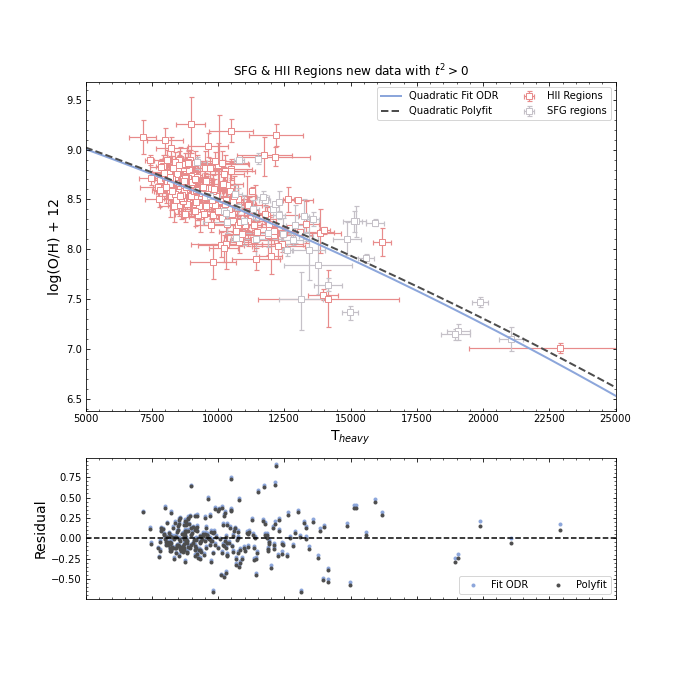

ORD a: -0.00000000134 ± 0.00000000149
ORD b: -0.00008370715 ± 0.00003488071
ORD c: 9.45718667553 ± 0.19747366785 

Poly a: -0.0000000012
Poly b: -0.0000849220
Poly c: 9.4758028606


In [17]:
# Create the Adjustment:

#Use 'Regions' to make Lineal adjustment ODR:

Quadratic_Model = model(Regions['T_heavy'], Regions['O_abundance'], Regions['e_T_heavy'], Regions['E_T_heavy'], 
            Regions['e_O_abundancem'], Regions['e_O_abundancep'])


#Lineal Model Plot:

fig, ax = plt.subplots(2, 1, figsize=(9.5, 9.5), sharex=False, gridspec_kw={'height_ratios': [3.5, 1.5]})

#X axis for the adjustment:
x = np.linspace(5000, 25000, len(Regions['T_heavy']))

# HII
ax[0].errorbar(HII['T_heavy'], HII['O_abundance'], xerr=[HII['e_T_heavy'], HII['E_T_heavy']],
               yerr=[HII['e_O_abundancem'], HII['e_O_abundancep']], fmt = 's', mec=colors['HII'],
                mfc='white', ecolor=colors['HII'], elinewidth=1.2, capsize=2.5, capthick=1.2, 
               alpha=1, label = 'HII Regions', zorder = 0)

#SFG
ax[0].errorbar(SFG['T_heavy'], SFG['O_abundance'], xerr = [SFG['e_T_heavy'], SFG['E_T_heavy']],
            yerr = [SFG['e_O_abundancem'], SFG['e_O_abundancep']],  fmt = 's',  mec=colors['SFG'],
                mfc='white', ecolor=colors['SFG'], elinewidth=1.2, capsize=2.5, capthick=1.2, 
               alpha=1,  label = 'SFG regions', zorder = 0,)

ax[0].plot(x,  np.dot(np.vander(x, 3), [Quadratic_Model[0][0], Quadratic_Model[0][2], Quadratic_Model[0][4] ] ),
           c = colors['ODR'], label = 'Quadratic Fit ODR', lw = 2, zorder = 1)

#Linregress
ax[0].plot(x, np.dot(np.vander(x, 3), [Quadratic_Model[1][0], Quadratic_Model[1][1], Quadratic_Model[1][2] ] ), '--',
           c = colors['Linregress'], label = 'Quadratic Polyfit', lw = 2, 
           zorder = 1)

ax[0].minorticks_on() #minorticks on
ax[0].tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True)
ax[0].set_title('SFG & HII Regions new data with $t^2 > 0$')
ax[0].set_ylabel(r'log(O/H) + 12', size = 14)
ax[0].set_xlabel(r'T$_{heavy}$', size = 14)
ax[0].set_xlim(5000,25000)
ax[0].grid(False)
ax[0].legend(ncol = 2)

ax[1].minorticks_on() #minorticks on
ax[1].tick_params(axis = 'both', which = 'both', direction = 'in', top = True, right = True)

ax[1].scatter(Regions['T_heavy'], Quadratic_Model[2], color=colors['ODR'], marker = '.', alpha=1, 
              label = 'Fit ODR', zorder = 0)
ax[1].scatter(Regions['T_heavy'], Quadratic_Model[3], color=colors['Linregress'], marker = '.', alpha=1, 
              label = 'Polyfit', zorder = 0)

ax[1].set_xlim(5000,25000)
ax[1].set_xticklabels([])
ax[1].axhline(0, color='k', linestyle='dashed')
ax[1].set_ylabel("Residual", size = 14)
ax[1].legend(loc = 'lower right', ncol = 2)

print(f"ORD a: {Quadratic_Model[0][0]:.11f} ± {Quadratic_Model[0][1]:.11f}") #Valor de a y su error
print(f"ORD b: {Quadratic_Model[0][2]:.11f} ± {Quadratic_Model[0][3]:.11f}") #Valor de b y su error
print(f"ORD c: {Quadratic_Model[0][4]:.11f} ± {Quadratic_Model[0][5]:.11f}", '\n') #Valor de c y sy error

print(f"Poly a: {Quadratic_Model[1][0]:.10f}")
print(f"Poly b: {Quadratic_Model[1][1]:.10f}")
print(f"Poly c: {Quadratic_Model[1][2]:.10f}")
plt.savefig('Quadratic_Model_t2geq0', dpi = 300)

## Resultados del modelo Cuadratico:

$$ 12 + \log_{10}(O/H)  = -(0.134 \pm 0.149) \dfrac{T_e^2}{10^8 k^2} - (0.837 \pm 0.348) \dfrac{T_e}{10^4k} + (9.4571 \pm 0.1974) $$ 

# CODIGO ANTES DEL MES DE MAYO DEL 2025
## TOMARLO COMO REFERENCIA

Total de Regiones SFG: 44
Total de Regiones HII: 230
Total de Regiones a estudiar: 274


<IPython.core.display.Javascript object>


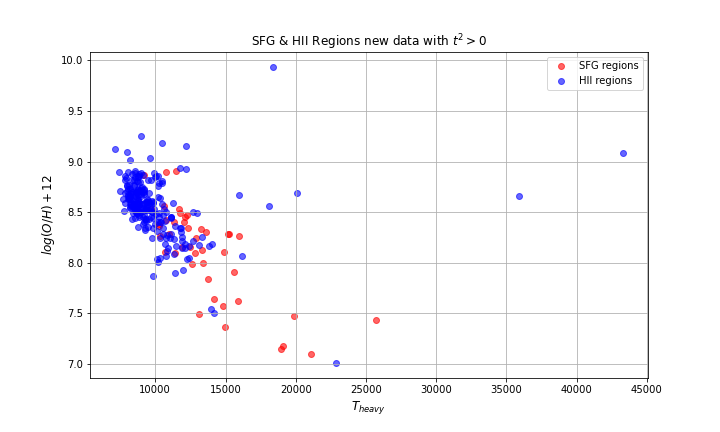

In [3]:
# We create mask for each regions:

#HII:
mask2 = ~np.isnan(ionic_HII_filter['O3_abundance']) & ~np.isnan(total_HII_filter['O_abundance'])& \
        ~np.isnan(physical_HII_filter['Te_[OIII]_4363_5007']) &~np.isnan(ionic_HII_filter['O2_abundance'])& \
        ~np.isnan(physical_HII_filter['Te_[NII]_5755_6584']) &~ np.isnan(physical_HII_filter['e_Te_[OIII]_4363_5007m'])& \
        ~np.isnan(physical_HII_filter['e_Te_[OIII]_4363_5007p']) & ~np.isnan(physical_HII_filter['e_Te_[NII]_5755_6584m'])& \
        ~np.isnan(physical_HII_filter['e_Te_[NII]_5755_6584p'])

#SFG:
mask = ~np.isnan(ionic_SFG_filter['O3_abundance']) & ~np.isnan(total_SFG_filter['O_abundance'])& \
        ~np.isnan(physical_SFG_filter['Te_[OIII]_4363_5007']) &~np.isnan(ionic_SFG_filter['O2_abundance'])\
        &~np.isnan(physical_SFG_filter['Te_[NII]_5755_6584']) &~ np.isnan(physical_SFG_filter['e_Te_[OIII]_4363_5007m'])\
        &~ np.isnan(physical_SFG_filter['e_Te_[OIII]_4363_5007p']) & ~np.isnan(physical_SFG_filter['e_Te_[NII]_5755_6584m'])\
        & ~np.isnan(physical_SFG_filter['e_Te_[NII]_5755_6584p'])


#This function estimate T_{heavy} using their total, ionic abundancese and temperatures fron O and N.

#DETERMINA LOS VALORES CENTRALES DE T_{Heavy}:

def T_heavy(O3, O2, O, Te_O3, Te_Ne): #Definimos nuestra función de T_pesada
    """"
    
    
    """
    T = 10**(O3 - O)*Te_O3 + 10**(O2 - O)*Te_Ne
    return round(T,2)

T_SFG = T_heavy(ionic_SFG_filter['O3_abundance'][mask],ionic_SFG_filter['O2_abundance'][mask], \
                total_SFG_filter['O_abundance'][mask], physical_SFG_filter['Te_[OIII]_4363_5007'][mask],\
                physical_SFG_filter['Te_[NII]_5755_6584'][mask])

T_HII = T_heavy(ionic_HII_filter['O3_abundance'][mask2],ionic_HII_filter['O2_abundance'][mask2], \
                total_HII_filter['O_abundance'][mask2], physical_HII_filter['Te_[OIII]_4363_5007'][mask2],\
                physical_HII_filter['Te_[NII]_5755_6584'][mask2])

print(r'Total de Regiones SFG:', len(T_SFG)) #DATOS DE TEMPERATURA PESADA PARA LAS REGIONES SFG
print(r'Total de Regiones HII:', len(T_HII)) #DATOS DE TEMPERATURA PESADA PARA LAS REGIONES HII

print(r'Total de Regiones a estudiar:' ,len(T_SFG)+ len(T_HII))

### Vamos a visualizar nuestras regiones de forma general para observar su comportamiento:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(T_SFG, total_SFG_filter['O_abundance'][mask],  c = 'r', label = 'SFG regions', alpha = 0.6)
ax.scatter(T_HII, total_HII_filter['O_abundance'][mask2], c = 'b', label = r'HII regions', alpha = 0.6)
ax.set_title('SFG & HII Regions new data with $t^2 > 0$')
ax.set_ylabel(r'$log(O/H) + 12$', size = 12)
ax.set_xlabel(r'$T_{heavy}$', size = 12)
plt.grid(True)
plt.legend()
plt.savefig('SFG_&_HII_Regions_with_NewData_t2geq0', dpi = 500)

In [4]:
### Contatenar:

#SFG:
Data_SFG = {'Name': total_SFG_filter['File'][mask],'O3_abundance': ionic_SFG_filter['O3_abundance'][mask], 
            'O2_abundance': ionic_SFG_filter['O2_abundance'][mask],'O_abundance': total_SFG_filter['O_abundance'][mask],
            'e_O_abundancem': total_SFG_filter['e_O_abundancem'][mask],
            'e_O_abundancep': total_SFG_filter['e_O_abundancep'][mask],
            'Te_[OIII]': physical_SFG_filter['Te_[OIII]_4363_5007'][mask], 
            'e_Te_[OIII]m':physical_SFG_filter['e_Te_[OIII]_4363_5007m'][mask],
            'e_Te_[OIII]p':physical_SFG_filter['e_Te_[OIII]_4363_5007p'][mask], 
            'Te_[NeII]': physical_SFG_filter['Te_[NII]_5755_6584'][mask],
            'e_Te_[NeII]m': physical_SFG_filter['e_Te_[NII]_5755_6584m'][mask],
            'e_Te_[NeII]p': physical_SFG_filter['e_Te_[NII]_5755_6584p'][mask],  
            'T_heavy': T_SFG}
df_SFG = pd.DataFrame(Data_SFG)

#HII:

Data_HII = {'Name': total_HII_filter['File'][mask2],'O3_abundance': ionic_HII_filter['O3_abundance'][mask2], 
            'O2_abundance': ionic_HII_filter['O2_abundance'][mask2],'O_abundance': total_HII_filter['O_abundance'][mask2],
            'e_O_abundancem': total_HII_filter['e_O_abundancem'][mask2],
            'e_O_abundancep': total_HII_filter['e_O_abundancep'][mask2], 
            'Te_[OIII]': physical_HII_filter['Te_[OIII]_4363_5007'][mask2],
            'e_Te_[OIII]m':physical_HII_filter['e_Te_[OIII]_4363_5007m'][mask2],
            'e_Te_[OIII]p':physical_HII_filter['e_Te_[OIII]_4363_5007p'][mask2],
            'Te_[NeII]': physical_HII_filter['Te_[NII]_5755_6584'][mask2], 
            'e_Te_[NeII]m': physical_HII_filter['e_Te_[NII]_5755_6584m'][mask2],
            'e_Te_[NeII]p': physical_HII_filter['e_Te_[NII]_5755_6584p'][mask2],
            'T_heavy': T_HII}

df_HII = pd.DataFrame(Data_HII)

print(len(df_SFG) + len(df_HII)) #Vemos si tenemos los mismos datos

#Concatenar:

df_new = pd.concat([df_SFG, df_HII])
df_new = df_new.reset_index()

274


In [39]:
### ESTA FUNCIÓN DETERMINA LOS ERRORES DE T_{Heavy} para cada uno de los datos a partir de un metodo MonteCarlo

def e_T_heavy(O3, O2, O, Te_O3, Te_Ne, e_Te_O3m, e_Te_O3p, e_Te_Nem, e_Te_Nep):
    
    #Número de muestras MonteCarlo
    n_samples = 10000
    
    #Listas vacias:

    e_T_list = [] #Arreglo vacio que almacenará los datos del error minus
    E_T_list = [] #Arreglo vacio que almacenará los datos del error plus

    #Vamos a crear una serie de simulaciones MonteCarlo para cada row de nuestro dataframe:
    
    for i in range(len(O3)):         
    
        #Hacemos una simulación MonteCarlo de 100000 muestras para cada Row de nuestro dataframe
        
        T_samples = np.random.standard_normal(n_samples)
        
        ##Primer termino de nuestra Ecuación de T_pesada:
        T_heavy1 = T_samples*(e_Te_O3m[i]/2 + e_Te_O3p[i]/2)*10**(O3[i] - O[i]) + 10**(O3[i] - O[i])*Te_O3[i]
        
        ##Primer termino de nuestra Ecuación de T_pesada:
        T_heavy2 = T_samples*(e_Te_Nem[i]/2 + e_Te_Nep[i]/2)*10**(O2[i] - O[i]) + 10**(O2[i] - O[i])*Te_Ne[i]   
    
        T_sum = T_heavy1 + T_heavy2   ##Suma de los terminos de nuestra función
    
        T_central = np.median(T_sum)
    
    
    
        e_Thp = round(np.percentile(T_sum, 84) - T_central,2)
        e_Thm = round(T_central - np.percentile(T_sum, 16),2)
        
        #Concatenar:
    
        e_T_list = np.append(e_T_list, np.absolute(e_Thm))
        E_T_list = np.append(E_T_list, np.absolute(e_Thp))
    
    
    return (e_T_list, E_T_list)

#Asignamos nuestros datos a una variable:

O3 = df_new['O3_abundance']
O2 = df_new['O2_abundance']
O = df_new['O_abundance']
Te_O3 = df_new['Te_[OIII]']
Te_Ne = df_new['Te_[NeII]']
e_Te_O3m = df_new['e_Te_[OIII]m']
e_Te_O3p = df_new['e_Te_[OIII]p']
e_Te_Nem = df_new['e_Te_[NeII]m']
e_Te_Nep = df_new['e_Te_[NeII]p']

e_T_total = e_T_heavy(O3, O2, O, Te_O3, Te_Ne, e_Te_O3m, e_Te_O3p, e_Te_Nem, e_Te_Nep)

df_new['e_T'], df_new['E_T'] = e_T_total[0], e_T_total[1]

### Notamos que tenemos datos outliers, vamos a quitarlos:

outlier = df_new[(df_new['O_abundance'] > 8.51) & (df_new['O_abundance'] < 10) & (df_new['T_heavy'] > 1.49e4) &\
                  (df_new['T_heavy'] < 5e4)]
outlier2 = df_new[(df_new['e_O_abundancem'] > 0.9) & (df_new['e_O_abundancem'] < 10)]

#outlier3 = df_new[(df_new['O_abundance'] > 6.9) & (df_new['O_abundance'] < 7.1) & (df_new['T_heavy'] > 1.6e4) &\
                  #(df_new['T_heavy'] < 2.5e4)]
#outlier4 = df_new[(df_new['O_abundance'] > 7.4) & (df_new['O_abundance'] < 7.5) & (df_new['T_heavy'] > 1.9e4) &\
                 #(df_new['T_heavy'] < 2e4)]
    

df_new2 = df_new.drop(outlier.index)
df_new2 = df_new2.drop(outlier2.index)
#df_new2 = df_new2.drop(outlier3.index)
#df_new2 = df_new2.drop(outlier4.index)
df_new2 = df_new2.reset_index(drop = True)



##Error en y:
yerr = [df_new2['e_O_abundancem'], df_new2['e_O_abundancep']]

##Error en x:
xerr = [df_new2['e_T'], df_new2['E_T']]
#df_new2
#outlier3

In [64]:
df_new2

,index,Name,O3_abundance,O2_abundance,O_abundance,e_O_abundancem,e_O_abundancep,Te_[OIII],e_Te_[OIII]m,e_Te_[OIII]p,Te_[NeII],e_Te_[NeII]m,e_Te_[NeII]p,T_heavy,e_T,E_T
0,2082,SFG__HS0924+3821__HS0924+3821__Izotov__04__,7.931,7.286,7.996,0.308,0.324,12439.46,166.32,215.27,13892.29,1880.81,2972.46,13419.08,626.08,645.65
1,2086,SFG__HS1213+3636A__HS1213+3636A__Izotov__04__,7.890,7.691,8.099,0.193,0.192,10652.44,274.57,229.38,12419.14,2017.19,1961.03,11437.29,958.01,901.19
2,2092,SFG__HS1851p6933__HS1851p6933__Izotov__21b__,8.241,7.025,8.266,0.033,0.033,16134.06,367.09,329.49,12199.87,441.41,289.62,15931.95,349.70,342.03
3,2096,SFG__HS2359+1659__HS2359+1659__Izotov__04__,7.447,6.524,7.496,0.311,0.272,11789.52,182.91,149.05,24306.05,5360.83,7415.31,13124.12,841.62,833.85
4,2099,SFG__Haro11__Haro11B__Guseva__12__,7.975,7.541,8.110,0.014,0.015,10032.83,75.34,61.70,12333.11,191.28,167.24,10679.46,95.04,100.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,1231,HII__SMC__NGC456-2__PenaGuerrero__12__,8.214,7.544,8.300,0.122,0.120,12089.50,266.08,151.26,11075.73,841.30,955.03,11860.19,335.27,324.40
261,1233,HII__SMC__NGC456-a-1__Guseva__11__,8.121,7.667,8.255,0.076,0.073,12167.86,95.71,105.28,11514.88,713.10,717.38,11910.90,257.18,262.44
262,1236,HII__SMC__NGC456-a-3-m__Guseva__11__,8.047,7.471,8.144,0.093,0.090,11951.43,81.23,96.14,12031.53,1079.28,997.38,12113.75,287.14,289.01
263,1237,HII__SMC__NGC456-a1__Guseva__11__,8.044,7.635,8.187,0.039,0.045,12176.60,79.81,87.73,11883.36,327.49,461.32,12094.24,170.62,170.54


<IPython.core.display.Javascript object>


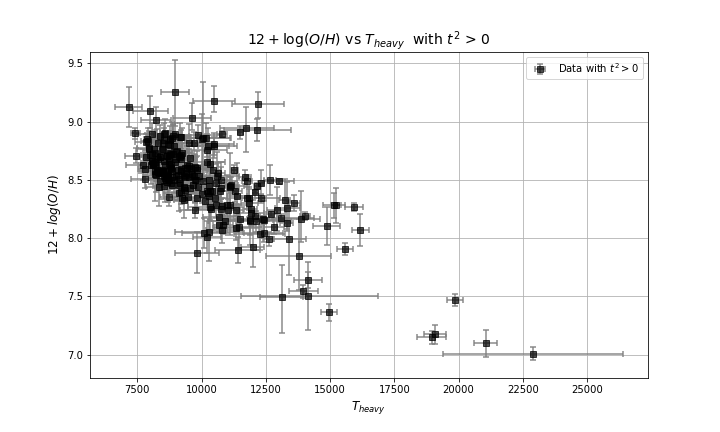

In [40]:
### Vamos a visualizar los datos

fig, ax = plt.subplots(figsize=(10,6))

ax.errorbar(df_new2['T_heavy'],df_new2['O_abundance'], xerr = xerr, yerr = yerr,fmt ='s', c = 'k', elinewidth = 2, 
            capsize=3, capthick = 2, ecolor= 'grey', label = r'Data with $t^{2} >0$', alpha = 0.7)
ax.set_ylabel('$12 + log(O/H)$', size = 12)
ax.set_xlabel('$T_{heavy}$', size = 12)
ax.set_title('$12 + \log(O/H)$ vs $T_{heavy}$  with $t^2$ > 0', size = 14)
plt.grid(True)
plt.legend()
ax.set_ylim(6.8, 9.6)
plt.savefig('Scatter_Data_OvsTheavy_with_NewData_t2geq0', dpi = 500)

## Ajuste Lineal Considerando errores en Log(O/H) y en $T_{heavy}$ 
### Ajuste Lineal ODR y Linregrees para todos los datos en conjunto:

In [41]:
#Esta funcion es para hacer ajustes lineales considerando barras de error tanto en eje x como en el eje y:

def linfit(x, y, xerr_low, xerr_high, yerr_low, yerr_high):
    
    #Definemos nuestros errores como:
    
    x_e = (xerr_low + xerr_high)/2
    y_e = (yerr_low + yerr_high)/2
    
    #definimos la forma de la funcion que queremos ajustar
    def func(p, x):

        m,b = p
        return m*x + b
 
    quad_model = odr.Model(func)
    
    # Create a RealData object
    data = odr.RealData(x, y, sx=x_e, sy=y_e)

    # Set up ODR with the model and data.
    odr_instance = odr.ODR(data, quad_model, beta0=[1., 1.])

    # Run the regression.
    out = odr_instance.run()

    #print fit parameters and 1-sigma estimates
    popt = out.beta
    perr = out.sd_beta
  
    c=popt[1]
    e_c=perr[1]
    
    m=popt[0]
    e_m=perr[0]

    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = stats.pearsonr(x, y)
    
    return  c, e_c, m, e_m, correlation_coefficient
#Eje x:

O = np.linspace(min(df_new2['T_heavy']), max(df_new2['T_heavy']), len(df_new2['T_heavy']))

#Ajuste ODR:

adjustment = linfit(df_new2['T_heavy'], df_new2['O_abundance'],df_new2['e_T'],df_new2['E_T'],
                    df_new2['e_O_abundancem'],df_new2['e_O_abundancep'])

print('Estos son los parametros del ajuste ODR:', adjustment)

#Linregess:

linre = stats.linregress(df_new2['T_heavy'], df_new2['O_abundance'])

print('Estos son los parametros del ajuste Linregress:', linre)

Estos son los parametros del ajuste ODR: (9.632086731579616, 0.05589998436707418, -0.0001151191599382601, 5.557125106449592e-06, -0.7681107680449984)
Estos son los parametros del ajuste Linregress: LinregressResult(slope=-0.00011492470793107589, intercept=9.65242824244822, rvalue=-0.7681107680449987, pvalue=7.707005363344326e-53, stderr=5.90754048526475e-06, intercept_stderr=0.061708194939411834)


<IPython.core.display.Javascript object>


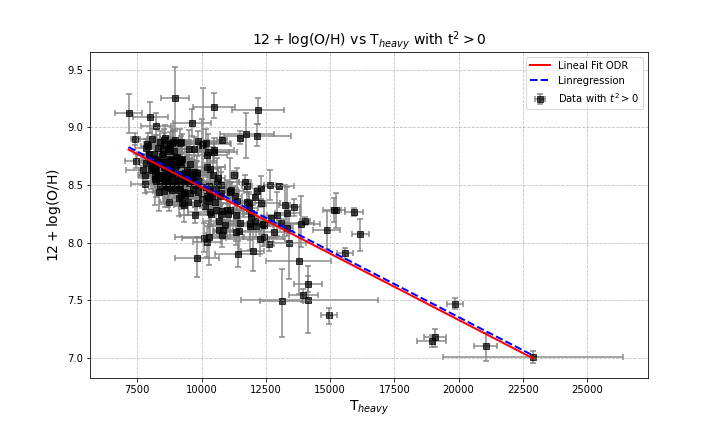

Slope ORD: -0.000115 ± 0.000006
Intercept ORD: 9.632087 ± 0.055900
Slope Linregress: -0.000115 ± 0.000006
Intercept Linregress:  9.6524 ± 0.0617


In [89]:
#Graficamos:

fig, ax = plt.subplots(figsize=(10,6))

ax.errorbar(df_new2['T_heavy'], df_new2['O_abundance'], xerr = xerr, yerr = yerr,fmt ='s', c = 'k', elinewidth = 2, 
            capsize=3, capthick = 2, ecolor= 'grey', label = 'Data with $t^2 > 0$', alpha = 0.7, zorder = 1)

# Intervalo de confianza (aproximado)
y_fit_upper = (adjustment[2] + adjustment[3]) *O + (adjustment[0] + adjustment[1])
y_fit_lower = (adjustment[2] - adjustment[3]) *O + (adjustment[0] - adjustment[1])

plt.plot(O, np.dot( np.vander(O, 2), [adjustment[2], adjustment[0]] ), c = 'r', label = 'Lineal Fit ODR', lw = 2, zorder = 2)

plt.plot(O, np.dot(np.vander(O, 2), [linre[0], linre[1]] ), '--', c = 'b', label = 'Linregression', lw = 2, zorder = 2)

print(f"Slope ORD: {adjustment[2]:.6f} ± {adjustment[3]:.6f}")
print(f"Intercept ORD: {adjustment[0]:.6f} ± {adjustment[1]:.6f}")

print(f'Slope Linregress: {linre[0]: .6f} ± {linre[4]:.6f}')
print(f'Intercept Linregress: {linre[1]: .4f} ± {0.06170819:.4f}')


ax.set_ylabel('$12 + \log$(O/H)', size = 14)
ax.set_xlabel('T$_{heavy}$', size = 14)
ax.set_title('$12 + \log$(O/H) vs T$_{heavy}$ with t$^2 > 0$', size = 14)
plt.grid(True, linestyle = '--', alpha = 0.8)
plt.legend(loc = 'upper right', fontsize = 'medium')
plt.savefig('LinealAdjustments_Theavy_vs_O_with_NewData_t2geq0', dpi = 300)

#### Residuos:

<IPython.core.display.Javascript object>


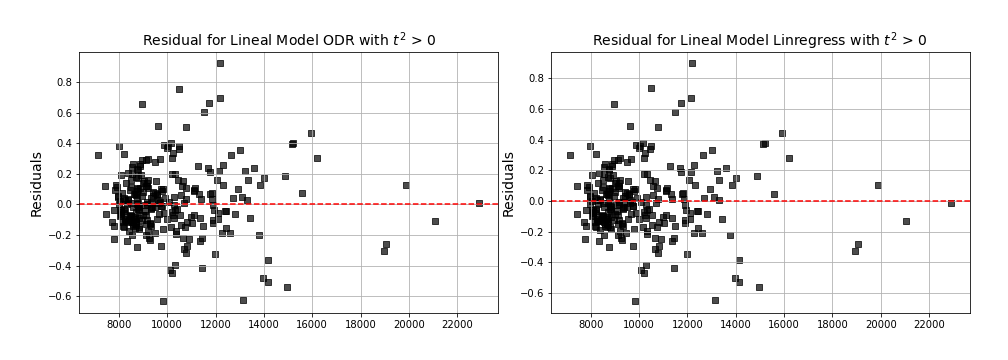

In [92]:
### Haremos el calculo de los residuos y ambos modelos y los vamos a comparar:

y_obs = df_new2['O_abundance']

#Residual ODR:

#Definimos la función para determinar los residuos de ODR:

y = adjustment[0] + adjustment[2]*df_new2['T_heavy']

Residual_ODR = y_obs - y

#Residual Linregress: 

#Definimos la función para determinar los residuos de Linregress:

y2 = linre[0]*df_new2['T_heavy'] + linre[1]

Residual_Linregress = y_obs - y2

#Graficamos:

fig, ax = plt.subplots(1,2, figsize= (14,5))


ax[0].scatter(df_new2['T_heavy'], Residual_ODR, color='black',marker = 's', alpha=0.7)
ax[0].axhline(0, color='red', linestyle='dashed')
ax[0].set_ylabel("Residuals", size = 14)
ax[0].set_title("Residual for Lineal Model ODR with $t^2$ > 0", size = 14)
#ax[0].set_ylim(-5000, 5000)
ax[0].grid(True)

fig.tight_layout(pad=3)

ax[1].scatter(df_new2['T_heavy'], Residual_Linregress, color='black', marker = 's', alpha=0.7)
ax[1].axhline(0, color='red', linestyle='dashed')
ax[1].set_ylabel("Residuals", size = 14)
ax[1].set_title("Residual for Lineal Model Linregress with $t^2$ > 0 ", size = 14)
#ax[1].set_ylim(-5000, 5000)
ax[1].grid(True)
plt.savefig('Residual_ODR&Linregress_with_NewData_t2geq0', dpi = 300)

### Ajuste Lineal MCMC:

In [15]:
#Definimos nuestra nueva likelihood:

#def log_likelihood(theta, x, y, em_y, ep_y, em_x, ep_x):
    
 #   xerr = (em_x + ep_x)/2
  #  yerr = (em_y + ep_y)/2
    
   # m, b= theta
    #model = m * x + b
    #sigma2 = (yerr**2 + (m*xerr)**2)
    #return -0.5 * np.sum((y - model) ** 2/sigma2 + np.log(2*np.pi*sigma2))

#np.random.seed(128)
#nll = lambda *args: -log_likelihood(*args)
#initial = np.array([-8600,83500]) + 1* np.random.randn(2)
#soln = minimize(nll, initial, args=(df_new2['O_abundance'], df_new2['T_heavy'], df_new2['e_T'], df_new2['E_T'],
 #                                   df_new2['e_O_abundancem'], df_new2['e_O_abundancep']))
#m_ml, b_ml  = soln.x

#print("Maximum likelihood estimates:")
#print("m = {0:.3f}".format(m_ml))
#print("b = {0:.3f}".format(b_ml))

In [16]:
#def log_prior(theta):
 #   m, b= theta
  #  if - 9339 < m < -7039 and  68022 < b < 90022:
   #     return 0.0
    #return -np.inf

#Combinando log_prior y log_likelihood obtenemos the full log-probability function:

#def log_probability(theta, x, y,em_y, ep_y, em_x, ep_x):
 #   lp = log_prior(theta)
  #  if not np.isfinite(lp):
   #     return -np.inf
    #return lp + log_likelihood(theta, x, y, em_y, ep_y, em_x, ep_x)

In [23]:
#pos = soln.x + 1*np.random.randn(32, 2)
#nwalkers, ndim = pos.shape

#ncpu = cpu_count()
#print("{0} CPUs".format(ncpu))

#with Pool(processes=15) as pool:
 #   sampler = emcee.EnsembleSampler(
  #  nwalkers, ndim, log_probability, args=(df_new2['O_abundance'], df_new2['T_heavy'], df_new2['e_T'], df_new2['E_T'], 
                                           #df_new2['e_O_abundancem'], df_new2['e_O_abundancep']), pool = pool)
   # sampler.run_mcmc(pos, 5000, progress=True);

In [24]:
#fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
#samples = sampler.get_chain()
#labels = ["Slope", "Intercept"]
#for i in range(ndim):
 #   ax = axes[i]
  #  ax.plot(samples[:, :, i], "k", alpha=0.3)
   # ax.set_xlim(0, len(samples))
    #ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

#axes[-1].set_xlabel("step number");

In [25]:
#flat_samples = sampler.get_chain(discard=50, thin=2, flat=True)
#print(flat_samples.shape)

#fig = corner.corner(flat_samples, labels=labels, truths=[soln.x[0], soln.x[1]], quantiles=(0.16, 0.84),levels=(0.68,0.95),
 #                   smooth= 1, show_titles = True, max_n_ticks = 4, title_kwargs={"fontsize": 12},color="black",
  #                  scale_hist = True);
#fig.tight_layout(pad=1)
#plt.savefig('CornerPlot_Lineal_Theavy_vs_O_ML_with_NewData_t2eq0', dpi = 500)

In [26]:
### GRAFICO:
#fig, ax = plt.subplots(figsize=(12,6))

#ax.errorbar(df_new2['O_abundance'], df_new2['T_heavy'], xerr = xerr, yerr = yerr,fmt ='s', c = 'k', elinewidth = 2, 
 #           capsize=3, capthick = 2, ecolor= 'grey', label = 'Data with $t^2 > 0$', alpha = 0.7, zorder = 1)

#inds = np.random.randint(len(flat_samples), size=1000)
#for ind in inds:
 #   sample = flat_samples[ind]
  #  plt.plot(df_new2['O_abundance'], np.dot(np.vander(df_new2['O_abundance'], 2), sample[:2]), "C1", c = 'Yellow',
   #          alpha=0.3)
    
#plt.plot(O, np.dot(np.vander(O, 2) , [soln.x[0], soln.x[1]]),   '--',c = 'r', zorder = 4,
 #        label = 'Maximum Likelihood Lineal Fit')



#ax.set_xlabel(r'$log(O/H) + 12$', size = 12)
#ax.set_ylabel(r'$T_{heavy}$', size = 12)
#ax.set_title('$T_{heavy}$ vs $\log(O/H)$ + 12 with $t^2 > 0$', size = 16)
#plt.grid(True)
#plt.legend()
#plt.savefig('LinealAdjustments_ML_Theavy_vs_O_with_NewData_t2eq0', dpi = 500)

In [27]:
### Residuos de ML:

#Residual_ML = y_obs - ( np.dot(np.vander(df_new2['O_abundance'], 2), [soln.x[0], soln.x[1]]) )

#Graficamos:

#fig, ax = plt.subplots(figsize= (12,7))

#ax.scatter(df_new2['O_abundance'], Residual_ML, color='black', marker = 's', alpha=0.7)
#ax.axhline(0, color='red', linestyle='dashed')
#ax.set_ylabel("Residual")
#ax.set_title("Residual for Maximum Likelihood Lineal Fit with $t^2 > 0$")
#ax[0].set_ylim(-5000, 5000)
#ax.grid(True)

#plt.savefig('Residual_Lineal_Maximun_Likelihood_with_NewData_t2geq0', dpi = 500)

## Ajuste Cuadratico

### Ajuste Cuadratico ODR y Polyfit

In [91]:
#esta funcion es para hacer ajustes cuadraticos considerando barras de error
def linfit2(x, y, xerr_low, xerr_high, yerr_low, yerr_high): #definimos función
    
    #Definemos nuestros errores como:
    
    x_e = (xerr_low + xerr_high)/2
    y_e = (yerr_low + yerr_high)/2
    
    #definimos la forma de la funcion que queremos ajustar, en este caso, cuadratica
    def quadratic(theta,x):
        a, b, c = theta
        model = a*x**2 + b*x + c
        return model
 
    quad_model = odr.Model(quadratic)
    
    # Create a RealData object
    data = odr.RealData(x, y, sx=x_e, sy=y_e)

    # Set up ODR with the model and data.
    odr_instance = odr.ODR(data, quad_model, beta0=[1,1,1])

    # Run the regression.
    out = odr_instance.run()

    #print fit parameters and 1-sigma estimates
    popt = out.beta
    perr = out.sd_beta
    
    a=popt[0]
    e_a=perr[0]
    
    b=popt[1]
    e_b=perr[1]
    
    c = popt[2]
    e_c = perr[2]
    


    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = stats.pearsonr(x, y)
    
    return  a, e_a, b, e_b, c, e_c, correlation_coefficient

#Hacemos nuestro ajuste cuadratico:

quadratic = linfit2(df_new2['T_heavy'], df_new2['O_abundance'],df_new2['e_T'],df_new2['E_T'], df_new2['e_O_abundancem'],
                    df_new2['e_O_abundancep']) #Le damos los valores a la función

print('Estos son los resultados de nuestro ajuste cuadratico ODR:', quadratic)

#Polifit:

poly = np.polyfit(df_new2['T_heavy'], df_new2['O_abundance'], 2)
print(poly)

Estos son los resultados de nuestro ajuste cuadratico ODR: (-1.392231501347919e-09, 1.4981457170534087e-09, -8.231387044878778e-05, 3.499107061101433e-05, 9.44895447670269, 0.19797805779096547, -0.7681107680449984)
[-1.18436569e-09 -8.49218983e-05  9.47580239e+00]


<IPython.core.display.Javascript object>


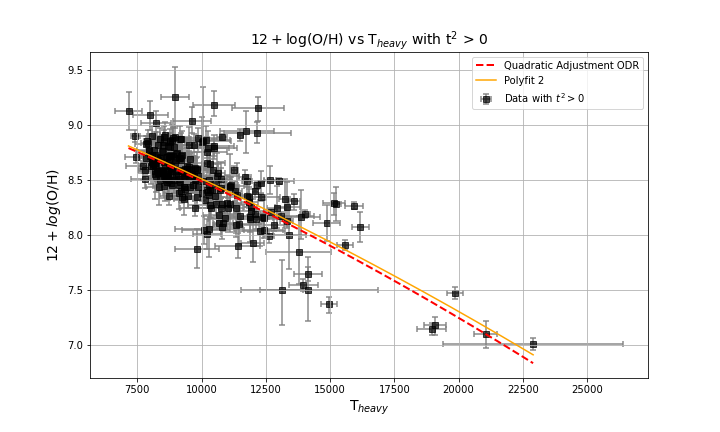

ORD a: -0.00000000139 ± 0.00000000150
ORD b: -0.00008231387 ± 0.00003499107
ORD c: 9.44895447670 ± 0.19797805779
Poly a: -0.0000000012
Poly b: -0.0000849219
Poly c: 9.4758023937
Podemos observar que el mejor ajuste para los datos el polyfit


In [99]:
#Graficamos:

fig, ax = plt.subplots(figsize=(10,6))

ax.errorbar(df_new2['T_heavy'], df_new2['O_abundance'], xerr = xerr, yerr = yerr,fmt ='s', c = 'k', elinewidth = 2, 
            capsize=3, capthick = 2, ecolor= 'grey', label = r'Data with $t^2 > 0$', alpha = 0.7, zorder = 1)

plt.plot(O, np.dot(np.vander(O, 3), [quadratic[0],quadratic[2], quadratic[4]]),'--', c = 'r', lw = 2, \
         label = 'Quadratic Adjustment ODR',  zorder = 2)


plt.plot(O, np.dot(np.vander(O,3), [poly[0], poly[1],poly[2]]), c = 'Orange', label = 'Polyfit 2')

print(f"ORD a: {quadratic[0]:.11f} ± {quadratic[1]:.11f}") #Valor de a y su error
print(f"ORD b: {quadratic[2]:.11f} ± {quadratic[3]:.11f}") #Valor de b y su error
print(f"ORD c: {quadratic[4]:.11f} ± {quadratic[5]:.11f}") #Valor de c y sy error

print(f"Poly a: {poly[0]:.10f}")
print(f"Poly b: {poly[1]:.10f}")
print(f"Poly c: {poly[2]:.10f}")


ax.set_ylabel('$12 + log$(O/H)', size = 14)
ax.set_xlabel('T$_{heavy}$', size = 14)
ax.set_title('$12 + \log$(O/H) vs T$_{heavy}$ with t$^2$ > 0', size = 14)
plt.grid(True)
plt.legend()
plt.savefig('Quadratic_Adjustment_OvsTheavy_t2geq0', dpi = 300)

print('Podemos observar que el mejor ajuste para los datos el polyfit')

#### Residuos:

<IPython.core.display.Javascript object>


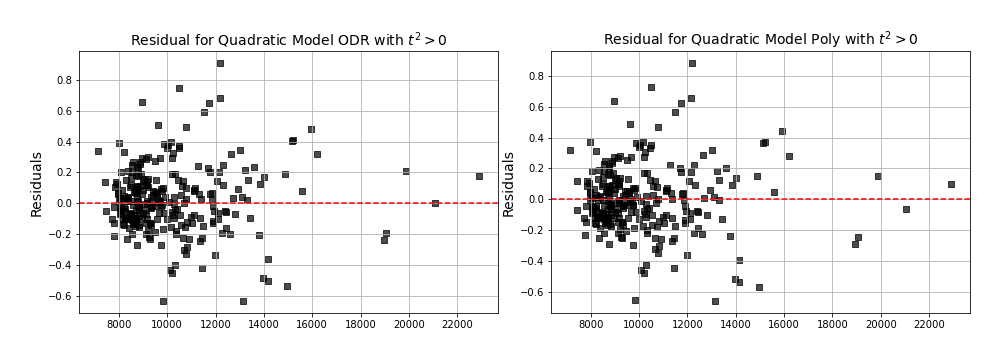

In [98]:
### Haremos el calculo de los residuos y ambos modelos y los vamos a comparar:


## Residuos ajuste cuadratico ODR:

Residual_Quadratic = y_obs - ( np.dot(np.vander(df_new2['T_heavy'], 3), [quadratic[0],quadratic[2], quadratic[4]]) )

## Residuios Ajuste PolyFit:

Residual_Quadratic_Poly = y_obs - ( np.dot(np.vander(df_new2['T_heavy'], 3), [poly[0], poly[1], poly[2]] ) )


#Graficamos:

fig, ax = plt.subplots(1,2, figsize= (14,5))



ax[0].scatter(df_new2['T_heavy'], Residual_Quadratic, color='black', marker = 's', alpha=0.7)
ax[0].axhline(0, color='red', linestyle='dashed')
ax[0].set_ylabel("Residuals", size = 14)
ax[0].set_title("Residual for Quadratic Model ODR with $t^2 > 0$", size = 14)
#ax.set_ylim(-5000, 5000)
ax[0].grid(True)

fig.tight_layout(pad=3)

ax[1].scatter(df_new2['T_heavy'], Residual_Quadratic_Poly, color='black', marker = 's', alpha=0.7)
ax[1].axhline(0, color='red', linestyle='dashed')
ax[1].set_ylabel("Residuals", size = 14)
ax[1].set_title("Residual for Quadratic Model Poly with $t^2 > 0$", size = 14)
#ax.set_ylim(-5000, 5000)
ax[1].grid(True)
plt.savefig('Residuals_QuadraticFit_ODR&Poly', dpi = 300)

<ipython-input-57-5aff65182077>:26: RuntimeWarning: invalid value encountered in divide
  result_average=weighted_mean.statistic / weights_sum.statistic
<ipython-input-57-5aff65182077>:32: RuntimeWarning: invalid value encountered in divide
  std_dev = np.sqrt((stats.binned_statistic(Xval, Yval ** 2 / (eYval ** 2),
<ipython-input-57-5aff65182077>:34: RuntimeWarning: invalid value encountered in divide
  (weighted_mean.statistic / weights_sum.statistic) ** 2)
<ipython-input-57-5aff65182077>:32: RuntimeWarning: invalid value encountered in sqrt
  std_dev = np.sqrt((stats.binned_statistic(Xval, Yval ** 2 / (eYval ** 2),


<IPython.core.display.Javascript object>


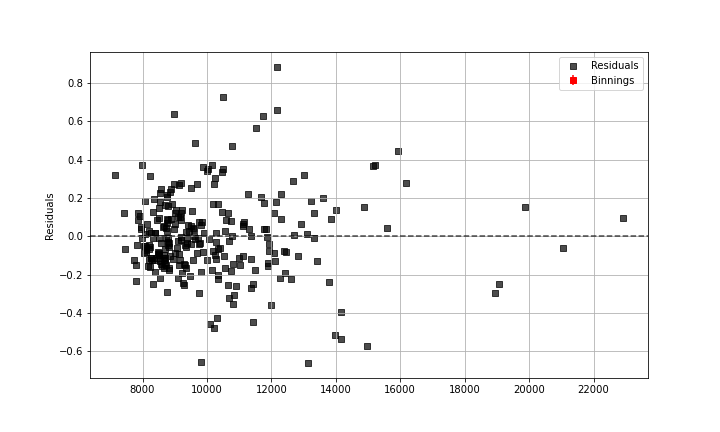

/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/matplotlib/axes/_base.py:2141: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


In [57]:
#Hacemos binning considerando el peso de los errores
def binning(Xval, em_x, ep_x,  Yval, em_y, ep_y, bin_size):
    
    eXval = (em_x + ep_x)/2
    eYval = (em_y + ep_y)/2

    # Remover np.nan de los datos
    valid_indices = ~np.isnan(Xval) & ~np.isnan(eXval) & ~np.isnan(Yval) & ~np.isnan(eYval)
   
    Xval = Xval[valid_indices]
    eXval = eXval[valid_indices]
    Yval = Yval[valid_indices]
    eYval = eYval[valid_indices]

    
    # Calcular el promedio ponderado por el inverso del cuadrado del error y la desviación estándar
    weighted_mean = stats.binned_statistic(Xval, Yval / (eYval ** 2),
                                     bins=np.arange(Xval.min(), Xval.max() + bin_size, bin_size), statistic='sum')
    
    
    weights_sum = stats.binned_statistic(Xval, 1 / (eYval ** 2),
                                   bins=np.arange(Xval.min(), Xval.max() + bin_size, bin_size), statistic='sum')



    result_average=weighted_mean.statistic / weights_sum.statistic
    
    
    # Calcular la desviación 
    
    
    std_dev = np.sqrt((stats.binned_statistic(Xval, Yval ** 2 / (eYval ** 2),
                                        bins=np.arange(Xval.min(), Xval.max() + bin_size, bin_size), statistic='sum').statistic / weights_sum.statistic) -
                      (weighted_mean.statistic / weights_sum.statistic) ** 2)


    bin_centers = (weighted_mean.bin_edges[:-1] + weighted_mean.bin_edges[1:]) / 2

    
    #eliminamos los promedios donde haya menos de 3 puntos en un bin
    booleano=(np.bincount(weighted_mean.binnumber.astype(int))<3)[1:]
    
    result_average[booleano]=np.nan
    std_dev[booleano]=np.nan
    
    return bin_centers, result_average, std_dev

binninas= binning(df_new2['T_heavy'], df_new2['e_T'], df_new2['E_T'], Residual_Quadratic_Poly, df_new2['e_O_abundancem'],\
        df_new2['e_O_abundancep'], 0.15)

#Graficamos:
fig, ax = plt.subplots(figsize= (10,6))


# Plot the binned medians
plt.scatter(df_new2['T_heavy'], Residual_Quadratic_Poly, color='black', marker = 's', alpha=0.7, label="Residuals")
ax.errorbar(binninas[0], binninas[1], yerr = binninas[2], color='red',fmt = 's', label='Binnings')
plt.axhline(0, color='k', linestyle='dashed', alpha=0.7)

plt.ylabel("Residuals")
#plt.title("Binned Median Residuals (0.2 dex bins)")
plt.legend()
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


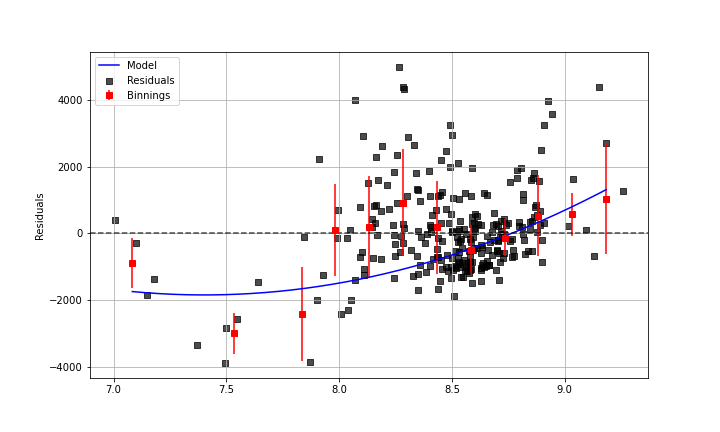

Parámetros ajustados: a = 995.1907388570959, b = -14733.108685881429, c = 52682.14823317693


In [32]:
### Vamos a ajustar a una función a nuestros resultados del binning donde los parametros seran los errores de nuestros \
### Parametros iniciales:

#Ajuste 
def quadratic_model_binning(O, M, std):
    
    #Definimos mascaras:
    mask = ~np.isnan(M) & ~np.isnan(std)
    O_mask = O[mask]
    M_mask = M[mask]
    std_mask = std[mask]
    
    #Definimos modelo:
    
    def quadratic_func(x, a, b, c):
        return a * x**2 + b * x + c

    # Ajuste de la función cuadrática
    popt, pcov = curve_fit(quadratic_func, O_mask, M_mask, sigma = std_mask, absolute_sigma=True)
    #poly = np.polyfit(O_mask, M_mask,2, w = 1/std_mask)

    # Parámetros ajustados
    a, b, c = popt
    #a,b,c = poly
    
    fig, ax = plt.subplots(figsize= (10,6))
    
    #Residuos:
    
    plt.scatter(df_new2['O_abundance'], Residual_Quadratic_Poly, color='black', marker = 's', alpha=0.7, label="Residuals")
    
    #Binnings:
    ax.errorbar(binninas[0], binninas[1], yerr = binninas[2], color='red',fmt = 's', label='Binnings')
    
    #Modelo:
    x_fit = np.linspace(min(binninas[0]), max(binninas[0]), 500)
    
    plt.plot(x_fit, np.dot(np.vander(x_fit, 3), [popt[0],popt[1],popt[2]]), color ='blue', label = 'Model' )
    
    plt.axhline(0, color='k', linestyle='dashed', alpha=0.7)
    plt.ylabel('Residuals')
    plt.legend(loc = 'best')
    plt.grid(True)
    plt.show()
    plt.savefig('Binnings', dpi = 500)
    return print(f"Parámetros ajustados: a = {a}, b = {b}, c = {c}")

model_binning = quadratic_model_binning(binninas[0], binninas[1], binninas[2])
model_binning

## AJUSTES QUE NO SE UTILIZARAN:
### Ajuste Cubico con ODR:

(4.284491151612408e-12, 1.507043334771117e-13, -1.661966589384171e-07, 3.785292454816012e-09, 0.0019208640602636883, 2.248996215214555e-05, 1.6888759302911411, 0.0, -0.7681107680449984)


<IPython.core.display.Javascript object>


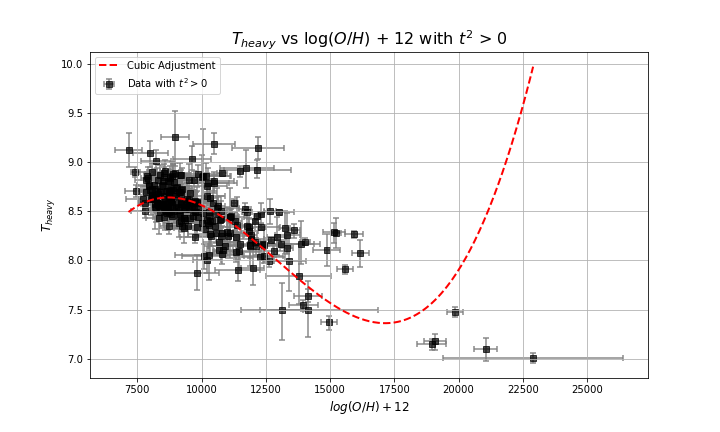

In [60]:
#esta funcion es para hacer ajustes cubicos considerando barras de error
def linfit3(x, y, xerr_low, xerr_high, yerr_low, yerr_high): #definimos función
    
    #Definemos nuestros errores como:
    
    x_e = (xerr_low + xerr_high)/2
    y_e = (yerr_low + yerr_high)/2
    
    #definimos la forma de la funcion que queremos ajustar, en este caso, cuadratica
    
    def cubic(theta,x):
        a, b, c, d = theta
        model = a*x**3 + b*x**2 + c*x + d
        return model
 
    cubic_model = odr.Model(cubic)
    
    # Create a RealData object
    data = odr.RealData(x, y, sx=x_e, sy=y_e)

    # Set up ODR with the model and data.
    odr_instance = odr.ODR(data, cubic_model, beta0=[2000, 1., 1., 1.])

    # Run the regression.
    out = odr_instance.run()

    #print fit parameters and 1-sigma estimates
    popt = out.beta
    perr = out.sd_beta
    
    a=popt[0]
    e_a=perr[0]
    
    b=popt[1]
    e_b=perr[1]
    
    c = popt[2]
    e_c = perr[2]
    
    d = popt[3]
    e_d = perr[3]
    

    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = stats.pearsonr(x, y)
    
    return  a, e_a, b, e_b, c, e_c, d, e_d, correlation_coefficient

#Hacemos nuestro ajuste cuadratico:

cubic = linfit3(df_new2['T_heavy'], df_new2['O_abundance'],df_new2['e_T'],df_new2['E_T'],df_new2['e_O_abundancem'],
                df_new2['e_O_abundancep']) #Le damos los valores a la función
print(cubic)

x = np.linspace(min(df_new2['T_heavy']), max(df_new2['T_heavy']), len(df_new2['T_heavy']))

#Graficamos:

fig, ax = plt.subplots(figsize=(10,6))

ax.errorbar(df_new2['T_heavy'], df_new2['O_abundance'], xerr = xerr, yerr = yerr,fmt ='s', c = 'k', elinewidth = 2, 
            capsize=3, capthick = 2, ecolor= 'grey', label = r'Data with $t^2 > 0$', alpha = 0.7, zorder = 1)

plt.plot(x, np.dot(np.vander(x, 4), [cubic[0], cubic[2], cubic[4], cubic[6]] ),'--', c = 'r', lw = 2, \
         label = 'Cubic Adjustment',  zorder = 2)

#print(f"a: {quadratic[0]:.4f} ± {quadratic[1]:.4f}") #Valor de a y su error
#print(f"b: {quadratic[2]:.4f} ± {quadratic[3]:.4f}") #Valor de b y su error
#print(f"c: {quadratic[4]:.4f} ± {quadratic[5]:.4f}") #Valor de c y sy error

ax.set_xlabel(r'$log(O/H) + 12$', size = 12)
ax.set_ylabel(r'$T_{heavy}$', size = 12)
ax.set_title('$T_{heavy}$ vs $\log(O/H)$ + 12 with $t^2$ > 0', size = 16)
plt.grid(True)
plt.legend()
#plt.savefig('Cubic_Adjustment_OvsTheavy_t2geq0', dpi = 500)

#### Ajuste a la Cuarta con ODR:

(11615.019322627637, 3425.381285666454, -368254.0180767408, 112023.13634202648, 4369062.6384640625, 1371869.9160109197, -22997388.134855844, 7455482.411076334, 45345144.35167899, 15169510.546297695, -0.7681108011290577)


<IPython.core.display.Javascript object>


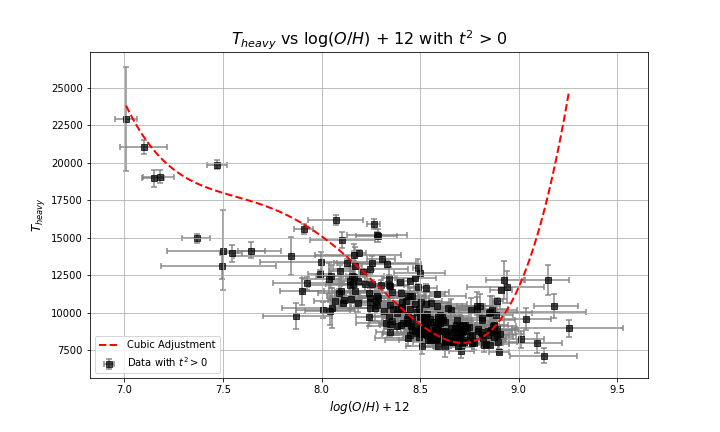

In [17]:
#esta funcion es para hacer ajustes cubicos considerando barras de error
def linfit4(x, y, xerr_low, xerr_high, yerr_low, yerr_high): #definimos función
    
    #Definemos nuestros errores como:
    
    x_e = (xerr_low + xerr_high)/2
    y_e = (yerr_low + yerr_high)/2
    
    #definimos la forma de la funcion que queremos ajustar, en este caso, cuadratica
    
    def cuarta(theta,x):
        a, b, c, d, e  = theta
        model = a*x**4 + b*x**3 + c*x**2 + d*x + e
        return model
 
    cuarta_model = odr.Model(cuarta)
    
    # Create a RealData object
    data = odr.RealData(x, y, sx=x_e, sy=y_e)

    # Set up ODR with the model and data.
    odr_instance = odr.ODR(data, cuarta_model, beta0=[0., 1., 1., 1., 1.])

    # Run the regression.
    out = odr_instance.run()

    #print fit parameters and 1-sigma estimates
    popt = out.beta
    perr = out.sd_beta
    
    a=popt[0]
    e_a=perr[0]
    
    b=popt[1]
    e_b=perr[1]
    
    c = popt[2]
    e_c = perr[2]
    
    d = popt[3]
    e_d = perr[3]
    
    e = popt[4]
    e_e = perr[4]
    

    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = stats.pearsonr(x, y)
    
    return  a, e_a, b, e_b, c, e_c, d, e_d, e, e_e, correlation_coefficient

#Hacemos nuestro ajuste cuadratico:

cuarto = linfit4(df_new2['O_abundance'], df_new2['T_heavy'], df_new2['e_O_abundancem'], df_new2['e_O_abundancep'], 
                    df_new2['e_T'],df_new2['E_T']) #Le damos los valores a la función
print(cuarto)

x = np.linspace(min(df_new2['O_abundance']), max(df_new2['O_abundance']), len(df_new2['O_abundance']))

#Graficamos:

fig, ax = plt.subplots(figsize=(10,6))

ax.errorbar(df_new2['O_abundance'], df_new2['T_heavy'], xerr = xerr2, yerr = yerr2,fmt ='s', c = 'k', elinewidth = 2, 
            capsize=3, capthick = 2, ecolor= 'grey', label = r'Data with $t^2 > 0$', alpha = 0.7, zorder = 1)

plt.plot(x, np.dot(np.vander(x, 5), [cuarto[0], cuarto[2], cuarto[4], cuarto[6], cuarto[8]] ),'--', c = 'r', lw = 2, \
         label = 'Cubic Adjustment',  zorder = 2)

#print(f"a: {quadratic[0]:.4f} ± {quadratic[1]:.4f}") #Valor de a y su error
#print(f"b: {quadratic[2]:.4f} ± {quadratic[3]:.4f}") #Valor de b y su error
#print(f"c: {quadratic[4]:.4f} ± {quadratic[5]:.4f}") #Valor de c y sy error

ax.set_xlabel(r'$log(O/H) + 12$', size = 12)
ax.set_ylabel(r'$T_{heavy}$', size = 12)
ax.set_title('$T_{heavy}$ vs $\log(O/H)$ + 12 with $t^2$ > 0', size = 16)
plt.grid(True)
plt.legend()
#plt.savefig('Cubic_Adjustment_OvsTheavy_t2geq0', dpi = 1000)